# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
import numpy as np
len(np.unique(y_train))

43

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

### A: Normalize_greyscale function
This function serves to change a color image to greyscale and then normalize the image to between 0.05 and 0.95

In [4]:
import cv2

# GreyScale and Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Turn Color image into Grayscale, and
    
    Normalize the image data with Min-Max scaling to a range of [0.05, 0.95]
    :param image_data: The image data to be normalized
    :return: Grayscaled and Normalized image data
    """
    # cv2.cvtColor converts (32, 32, 3) to (32, 32)
    gray_image = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
      
    # Add a channel back so it's (32, 32,  1)
    gray_image = np.expand_dims(gray_image, axis=3)
    
    a = 0.05
    b = 0.95
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (gray_image - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

In [5]:
# Load the signal classid and names
import pandas as pd
signnames = pd.read_csv("signnames.csv")

In [6]:
signnames[5:10]

,ClassId,SignName
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [7]:
signnames.loc[0]['SignName']

'Speed limit (20km/h)'

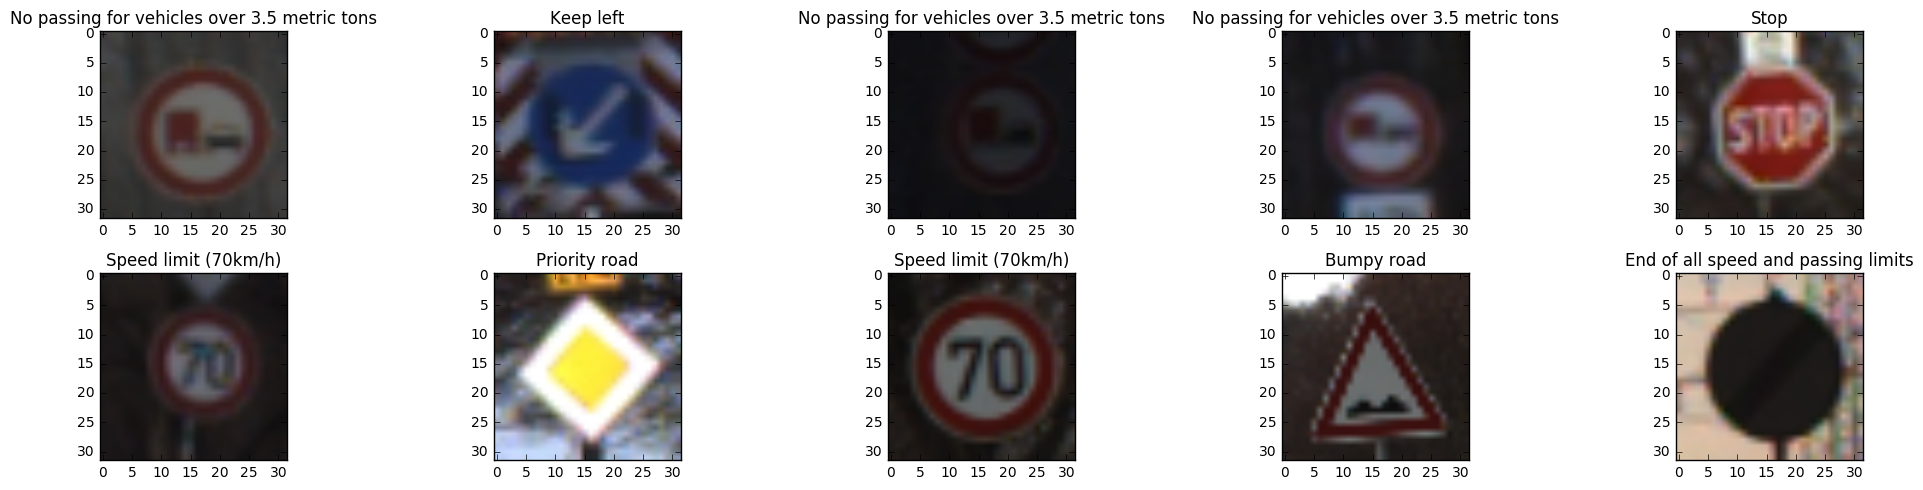

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
n_display_images = 10
rand_list = random.sample(range(n_train), n_display_images)

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.rcParams["figure.figsize"] = [20, 5]
#plt.figure(figsize=(3,3))
for i, index in enumerate(rand_list):
    plt.subplot(2, 5, i+1)
    plt.tight_layout()
    plt.imshow(X_train[index])
    plt.title("%s" % signnames.loc[y_train[index]]['SignName'])

plt.show()

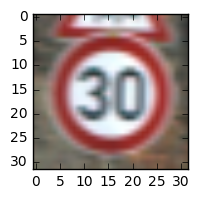

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[1000])

The traffic dataset has some very bright and some very dimmed images.  I'll need to normalize the brightness before training the model.

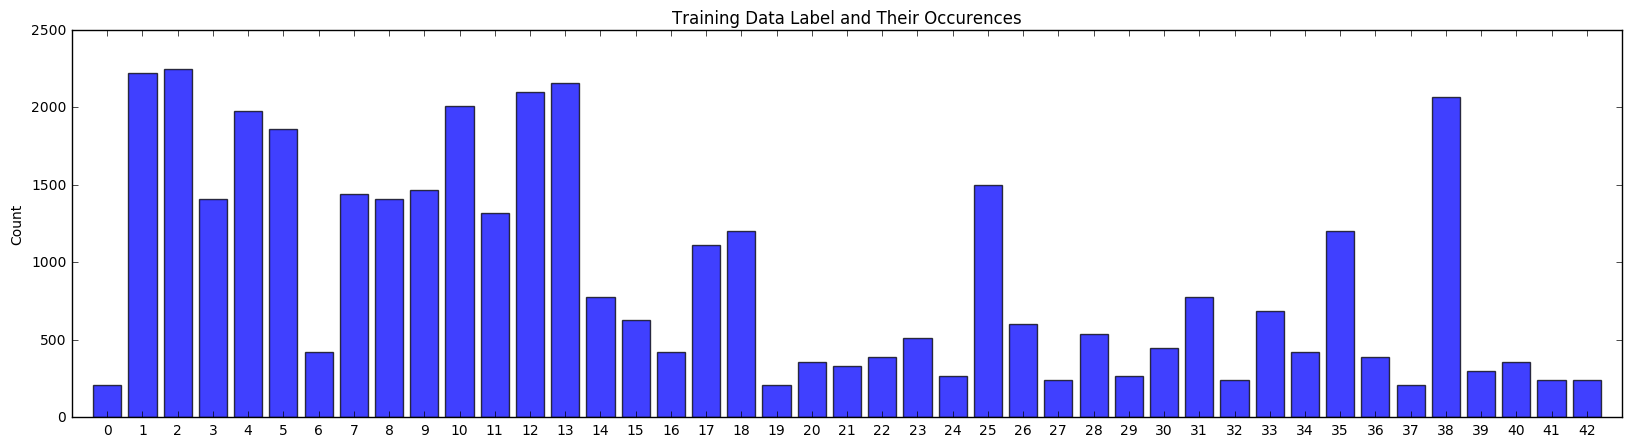

In [10]:
# How many images of each label do we have? 
label, count = np.unique(y_train, return_counts=True)

axes = plt.gca()
axes.set_xlim([-1,n_classes])

y_pos = np.arange(n_classes)

plt.bar(label, count, tick_label=label, align='center', alpha = 0.75)
plt.xticks(y_pos, label)
plt.ylabel('Count')
plt.title('Training Data Label and Their Occurences')

plt.show()

Here's an example on how the transform_image( ) applies to the "Speed limit (30km/h)" label image.

The training data has many examples for label 1-5, 7-13, 17, 18, 25, 31, 33, 35 and 38 and very few of the others.
This does not present a very balanced dataset.  For example, the model will have very few label 0 examples from which 
to train. 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
# This is with ORIGINAL Data

### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Create a greyscaled and normalized version of X_train & X_test data
X_train_scaled = []
X_test_scaled = []

print ("Scaling X_train ...")
for i in range(n_train):
    if (i % 2500 == 0):
        print ("i:", i)
    X_train_scaled.append(normalize_greyscale(X_train[i]))

print ("Scaling X_test ...")
for j in range(n_test):
    if (j % 2500 == 0):
        print ("j:", j)
    X_test_scaled.append(normalize_greyscale(X_test[j])) 

# The labeled data is not scaled but make a copy to be used for the scaled Trained & Test data
y_train_for_scaled = y_train
y_test_for_scaled = y_test

Scaling X_train ...
i: 0
i: 2500
i: 5000
i: 7500
i: 10000
i: 12500
i: 15000
i: 17500
i: 20000
i: 22500
i: 25000
i: 27500
i: 30000
i: 32500
i: 35000
i: 37500
Scaling X_test ...
j: 0
j: 2500
j: 5000
j: 7500
j: 10000
j: 12500


In [12]:
# Checking out the dimensions of datasets
# Need to convert a list back to ndarray for TF
X_train_scaled = np.array(X_train_scaled)

print("1:", type(X_train_scaled))
print(X_train_scaled.shape, y_train_for_scaled.shape)

# Need to convert a list back to ndarray for TF
X_test_scaled = np.array(X_test_scaled)

print("2:", type(X_test_scaled))
print(X_test_scaled.shape, y_test.shape)

X_test_data = X_test_scaled

1: <class 'numpy.ndarray'>
(39209, 32, 32, 1) (39209,)
2: <class 'numpy.ndarray'>
(12630, 32, 32, 1) (12630,)


In [13]:
print("Updated Image Shape: {}".format(X_train_scaled[0].shape))

Updated Image Shape: (32, 32, 1)


In [14]:
from sklearn.model_selection import train_test_split

# Create a Training and Validation data set
n_validation = int(n_train * 0.2)
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_train_scaled, y_train_for_scaled, test_size=n_validation, random_state=789, stratify=y_train_for_scaled)

## Model - 1: Initialization

In [15]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

## Model - 2: LeNet-5

In [16]:
from tensorflow.contrib.layers import flatten

def LeNet_drop(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
       
    # Note https://www.tensorflow.org/api_docs/python/nn/convolution
    # For the 'VALID' padding, the output height and width are computed as:
    #    out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    #    out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    
    # Therefore,
    #   28 = ceil(float(32 - filter_height + 1) / float(1)))
    #   28 = ceil(33 - filter_height)
    #   filter_height = 33 - 28 = 5  => shape=(5, 5, 1, 6)  
    #   note: 6 is the output dimension

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') 

    # Dropout (if training then keep_prob < 1 otherwise for test & validation keep_prob = 1)
    # conv1 = tf.nn.dropout(conv1, keep_prob)       

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
       
    # Calculate the shape needed for input 14x14x6 to 10x10x16 required output layer
    #    10 = ceil((14 - filter_height + 1) / 1)
    #    filter_height = 5  => shape=(5, 5, 6, 16)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout (if training then keep_prob < 1 otherwise for test & validation keep_prob = 1)
    # conv2 = tf.nn.dropout(conv2, keep_prob)     

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
      
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
       
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout (if training then keep_prob < 1 otherwise for test & validation keep_prob = 1)
    fc1 = tf.nn.dropout(fc1, keep_prob)    

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Dropout (if training then keep_prob < 1 otherwise for test & validation keep_prob = 1)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43 -> changed to 43 classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
       
    return logits

## Model - 3: Features and Labels

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

## Model - 4: Training Pipeline

In [18]:
rate = 0.001

logits = LeNet_drop(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model - 5: Model Evaluation

In [19]:
from time import time 

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Model - 6: Train the Model

In [20]:
from sklearn.utils import shuffle

# Starting Time
t0 = time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_data)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_data, y_train_data = shuffle(X_train_data, y_train_data)
        for offset in range(0, num_examples, BATCH_SIZE):           
            end = offset + BATCH_SIZE
            #print("offset: ",offset)
            #print("end: ",end)            
            batch_x, batch_y = X_train_data[offset:end], y_train_data[offset:end]
            #print("batch_y.shape:", batch_y.shape)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        # Use evaluate_test with NO dropout
        #validation_accuracy = evaluate(X_valid_data, y_valid_data)
        validation_accuracy = accuracy_operation.eval(feed_dict={
            x: X_valid_data, y: y_valid_data, keep_prob: 1.0})
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # Total Training time
    print("   Training Time:", round(time()-t0, 3), "s")
    print("\n\n")
    
    # Evaluate Test Accuracy - Use evaluate_test with NO dropout
    print("Evaluating Test Accuracy:")
    test_accuracy = accuracy_operation.eval(feed_dict={
        x: X_test_scaled, y: y_test, keep_prob: 1.0})
    
    #evaluate(X_test_scaled, y_test)
    print("   Test Accuracy = {:.3f}".format(test_accuracy))
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet-for-traffic-sign-dropout')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.654

EPOCH 2 ...
Validation Accuracy = 0.802

EPOCH 3 ...
Validation Accuracy = 0.865

EPOCH 4 ...
Validation Accuracy = 0.897

EPOCH 5 ...
Validation Accuracy = 0.919

EPOCH 6 ...
Validation Accuracy = 0.926

EPOCH 7 ...
Validation Accuracy = 0.937

EPOCH 8 ...
Validation Accuracy = 0.941

EPOCH 9 ...
Validation Accuracy = 0.953

EPOCH 10 ...
Validation Accuracy = 0.959

EPOCH 11 ...
Validation Accuracy = 0.959

EPOCH 12 ...
Validation Accuracy = 0.965

EPOCH 13 ...
Validation Accuracy = 0.970

EPOCH 14 ...
Validation Accuracy = 0.957

EPOCH 15 ...
Validation Accuracy = 0.968

EPOCH 16 ...
Validation Accuracy = 0.971

EPOCH 17 ...
Validation Accuracy = 0.973

EPOCH 18 ...
Validation Accuracy = 0.973

EPOCH 19 ...
Validation Accuracy = 0.978

EPOCH 20 ...
Validation Accuracy = 0.977

   Training Time: 219.855 s



Evaluating Test Accuracy:
   Test Accuracy = 0.916
Model saved


## Model - 7: Test Evaluation

In [21]:
import os

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet-for-traffic-sign-dropout.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = accuracy_operation.eval(feed_dict={
        x: X_test_scaled, y: y_test, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.916


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I chose to change the color images with 3 colors (e.g. 3 channels) to gray-scale (2 channel) so the model does not use the color as a signal.  I also wanted to use LeNet-5 model so I added a channel back so the input dimension is 32 x 32 x 1 as required. I scaled all the images to be between 0.05 and 0.95 to equalize the bright and dim pictures thus all features for all the images are in the same range for ease of training (e.g. the model won't favor extremely bright or dim features).

I wrote the following function, ** normalize_greyscale( ) **, to greyscale and normalize image data which uses the cv2 package to convert color to gray image.  I could have used a simple average (R + G + B)/3 but since a package is already developed and tested by a large community, I've decided to use that.  While I'm preprocessing the training data, I was sure to preprocess the testing data at the same time.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I've tried sampling 10%, 20% and 25% of the training data as validation data to be used during training.  I used scikit-learn's train_test_split( ) to randomly select 20% (shown in code below) of the training data as validation data.  I set a random_state so the result is reproducible.

Even though during data exploration I've found that some labels had very few samples (e.g. label 0) in the data set. 
I performed the basic LeNet modeling with original training data and my test accuracy was around 87%. 

I thought maybe some of the labels were under-represented and so I tried generating new data with applying rotation, shearing and transformation (per https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6).  The test accuracy in fact dropped to 85.5%. It could be that I did not generate enough variations from different provided signs.  So, I went back to modeling with the provided images instead.

In [22]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

# Create a Training and Validation data set
n_validation = int(n_train * 0.2)
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_train_scaled, y_train_for_scaled, test_size=n_validation, random_state=789)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I chose the LeNet-5 architecture with 1 dropout layer:

* 1st convoluation layer with 5x5 kernel, stride of 1 and VALID padding 
* RelU activation
* Max Pooling with 2x2 kernel, stride of 2 and VALID padding
* 2nd convolution layer with 5x5 kernel, stride of 1 and VALID padding
* RelU activation
* Max Pooling with 2x2 kernel, stride of 2 and VALID padding
* Fully-connected layer, a flattened layer with 400 hidden units
* Fully-connected layer with 120 hidden units
* RelU activation
* Dropout (keep_prob = 0.75)
* Fully-connected layer with 43 units (to match the 43 different class labels)

For code see above section marked ** Model - 1: Initialization to Model - 7: Test Evaluation **.


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the following:

- LeNet-5 model 
- Optimizer is the AdamOptimizer
- batch size = [128, 256, 512]
- epochs = [10, 20, 30]
- mu = 0 but varied sigma from 0.001 to 0.1 
- dropout in the final fully-connected layer with keep_prob=0.75

The smaller the sigma the model didn't learn very fast or at all and will even stop learning after 1-2 epochs.
The same goes with learning rate.  The smaller the learning rate the slower the model learned and sometimes did not improve even after 20 EPOCHS.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Since the exercise suggested to start with the LeNet-5 model, I started from there.  The challenge I faced was the LeNet-5 model takes a (n, 32, 32, 1) input array and the German traffic dataset was in color (n, 32, 32, 3).  There were many ways to reduce the 3 color channels into 1.  I finally settled in using the grayscale but that changed the array to (n, 32, 32) and not (n, 32, 32, 1).  After some research and googling, I've found **np.expand_dims( )** function which expands dimension of an array.

Using the LeNet-5 model seems reasonable because it was used to classify images into 10 catagory of digits from 0 to 9. It seems like an applicable architecture for the German traffic sign dataset which is also images but with many more classes.  After adjusting the final fully-connected layer to output 43 classes, it worked great.

I've tried with modeling with original data and then with generated data but I didn't see test accuracy improvement with generated data.  In addition, when this LeNet5 model was applied to the new images in the next step, it didn't improve nor degrade the prediction accuracy.  I went back to modeling with original training data and then implemented a dropout layer with LeNet5 model.  This seems to work better and increase test accuracy to 90%.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

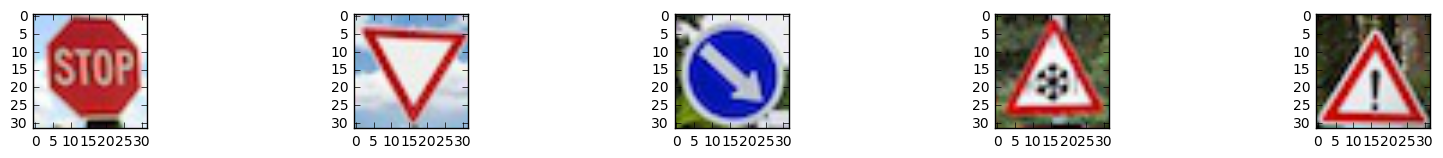

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from PIL import Image

n_new_images = 5
new_images = []

for i in range(n_new_images):
    filename = 'traffic_sign' + str(i) + '.jpg'
    image = Image.open(filename)
    new_images.append(image)
    
for i, image in enumerate(new_images):
    plt.subplot(3, 5, i+1)
    plt.imshow(image)

I searched for traffic signs from images.google.com and downloaded some traffic sign pictures.  I processed this data by cropping out extraneous stuff such as trees, parking lot and other background and resized each image to 32x32 pixels.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I chose the first 5 images to make predictions from the LeNet-5 model since they seem to have a good representation from the training dataset.  Some signs are in partial shade and some are at an angle so the perspective of the image is not straight on which might pose a challenge for the classifer.

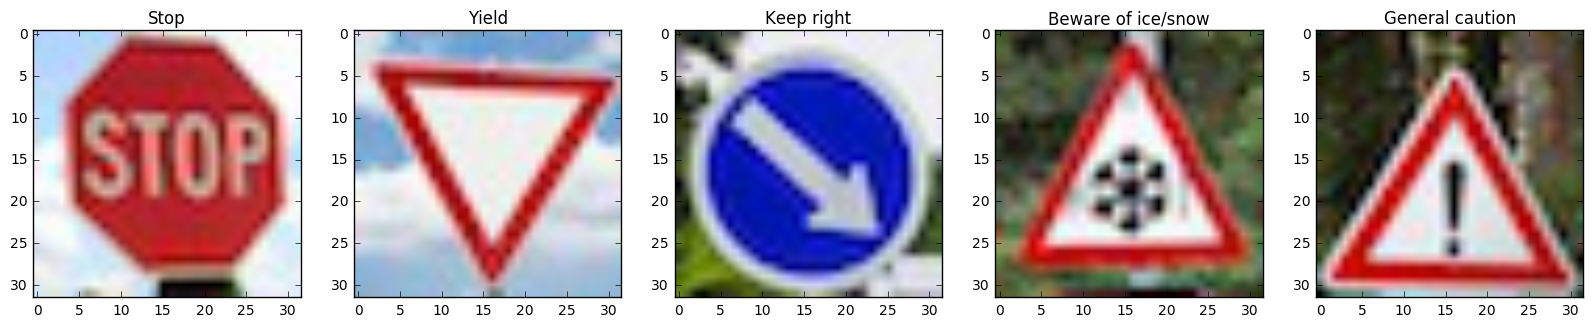

In [24]:
n_new_images = 5
X_new_image_data = []

# Define the new image labels based on signnames.csv definitions
y_new_images = [14, 13, 38, 30, 18]

for i in range(n_new_images):
    # Print just 5 chosen images
    plt.subplot(1, 5, i+1)
    plt.imshow(new_images[i])
    plt.title("%s" % signnames.loc[y_new_images[i]]['SignName'])
    
    image = new_images[i]
    image = np.array(list(image.getdata()))
    image = np.reshape(image, (32, 32, 3))
    X_new_image_data.append(image)
 

In [25]:
X_new_image_data = np.array(X_new_image_data, dtype='uint8')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Out of the 5 new images, the model was able to predict 4 images correctly.  I would say it performed better than expected.  The last "General Caution" sign in a 32x32 resolution looks very similar some of the training set images such as "Traffic Signals" and the "Pedestrians" signs.

In [26]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Preprocess the new image data
X_new_scaled = []

for i in range(n_new_images):
    X_new_scaled.append(normalize_greyscale(X_new_image_data[i]))

In [31]:
# Define softmax_prediction to be saved out during calculations
softmax_prediction = tf.nn.softmax(logits)

# A Function to return the logits and softmax predictions
def get_pred(X_data, y_data):
    num_examples = len(X_data)

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        correct_pred, softmax_pred = sess.run([correct_prediction, softmax_prediction], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
    return correct_pred, softmax_pred    

In [33]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet-for-traffic-sign-dropout.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

#    test_accuracy = evaluate(X_new_scaled, y_new_images)
#    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    test_pred, softmax_pred = get_pred(X_new_scaled, y_new_images)
    
    print("Test Prediction:", test_pred)
    
    print("softmax_pred:", softmax_pred)

Test Prediction: [ True  True  True False False]
softmax_pred: [[  9.76924866e-07   1.78144295e-02   2.75254279e-04   1.97907966e-08
    1.56599469e-06   6.67481270e-09   2.45950812e-11   4.42427171e-12
    9.46232981e-10   2.57645238e-10   1.51035575e-12   9.44374134e-10
    4.18333919e-08   2.59906574e-06   9.81882036e-01   6.42761080e-08
    5.10369842e-17   2.00962677e-06   3.29808708e-10   1.53228112e-15
    1.57521815e-10   1.48990686e-08   1.00338786e-10   2.60478375e-11
    2.53751598e-09   2.22178051e-06   1.09523306e-07   1.05783676e-12
    4.32977265e-11   3.26571187e-10   1.32843714e-09   3.92396471e-09
    8.25807600e-09   1.62673059e-05   1.05653986e-09   1.99991113e-09
    7.31726513e-10   7.82144269e-08   1.87359592e-06   3.70687161e-07
    1.56093694e-10   5.62929532e-13   5.76265465e-18]
 [  0.00000000e+00   0.00000000e+00   2.61057848e-30   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.15098982e-34   0.000

In [34]:
# Get the index of the max value for each row
label_of_max_prob = np.argmax(softmax_pred, axis=1)
label_of_max_prob

array([14, 13, 38, 23, 27])

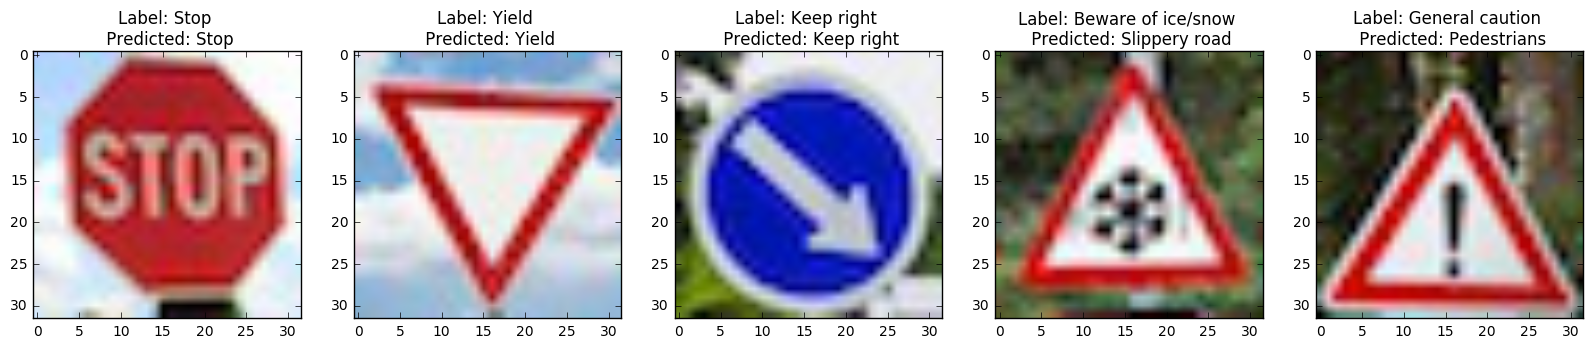

In [35]:
for i in range(n_new_images):
    # Print just 5 chosen images
    plt.subplot(1, 5, i+1)
    plt.imshow(new_images[i])
    plt.title("Label: %s \n Predicted: %s" % (signnames.loc[y_new_images[i]]['SignName'], signnames.loc[label_of_max_prob[label[i]]]['SignName']))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

I'll write a new function to return the top k values and its associated index for visualization later.

In [41]:
def get_top_k(X_data, y_data, top_k_number):
    num_examples = len(X_data)

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        correct_pred, softmax_pred = sess.run([correct_prediction, softmax_prediction], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        
        top_k_values, top_k_indices = tf.nn.top_k(softmax_pred, k=top_k_number, sorted=True)
        
        # Convert tensfors to arrays
        top_k_val = np.array([top_k_values.eval()])
        top_k_idx = np.array([top_k_indices.eval()])
    
    return top_k_val, top_k_idx

In [42]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet-for-traffic-sign-dropout.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    #test_accuracy = evaluate(X_new_scaled, y_new_images)
    test_accuracy = accuracy_operation.eval(feed_dict={
        x: X_new_scaled, y: y_new_images, keep_prob: 1.0})
    
    top_k_val, top_k_idx = get_top_k(X_new_scaled, y_new_images, 5)    

In [43]:
print(top_k_idx)
print(top_k_val)

[[[14  1  2 33 13]
  [13 35  2  9 15]
  [38 34 13 15 36]
  [23 30 29 28 11]
  [27 24 11 18 26]]]
[[[  9.81882036e-01   1.78144295e-02   2.75254279e-04   1.62673059e-05
     2.59906574e-06]
  [  1.00000000e+00   6.45668856e-29   2.61057848e-30   2.15098982e-34
     2.80004046e-35]
  [  1.00000000e+00   2.09290989e-16   6.20556256e-17   7.35099497e-21
     8.72595575e-22]
  [  5.91625810e-01   4.07856196e-01   1.82739808e-04   1.58252980e-04
     6.54154646e-05]
  [  9.97405350e-01   2.56022741e-03   3.14851750e-05   2.63062861e-06
     2.49570633e-07]]]


In [44]:
def display_image_pred(idx, images, top_k_val, top_k_idx, signnames, y_new_imagesdx):
    plt.figure(figsize=(3,3))
    plt.imshow(images[idx])
    true_label = signnames.loc[y_new_images[idx]]['SignName']
    pred_label1 = signnames.loc[top_k_idx[0, idx, 0]]['SignName']
    pred_label2 = signnames.loc[top_k_idx[0, idx, 1]]['SignName']
    pred_label3 = signnames.loc[top_k_idx[0, idx, 2]]['SignName']
    pred_label4 = signnames.loc[top_k_idx[0, idx, 3]]['SignName']
    pred_label5 = signnames.loc[top_k_idx[0, idx, 4]]['SignName']
    
    print ("True label:", true_label)
    print ("pred_label1 %-25s:  prob: %.19f" % (pred_label1, top_k_val [0, idx, 0]))   
    print ("pred_label2 %-25s:  prob: %.19f" % (pred_label2, top_k_val [0, idx, 1]))
    print ("pred_label3 %-25s:  prob: %.19f" % (pred_label3, top_k_val [0, idx, 2]))
    print ("pred_label4 %-25s:  prob: %.19f" % (pred_label4, top_k_val [0, idx, 3]))
    print ("pred_label5 %-25s:  prob: %.19f" % (pred_label5, top_k_val [0, idx, 4])) 
    
    plt.title("Label: %s " % true_label)

### Visualizing the softmax probabilities and the top 5 predictions for each new image

The following outputs the top 5 probabilities and its associated label name for the new images downloaded.

True label: Stop
pred_label1 Stop                     :  prob: 0.9818820357322692871
pred_label2 Speed limit (30km/h)     :  prob: 0.0178144294768571854
pred_label3 Speed limit (50km/h)     :  prob: 0.0002752542786765844
pred_label4 Turn right ahead         :  prob: 0.0000162673059094232
pred_label5 Yield                    :  prob: 0.0000025990657377406


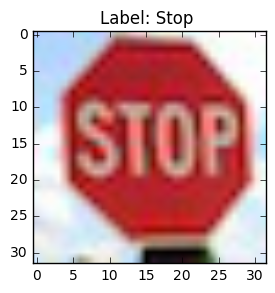

In [45]:
display_image_pred(0, new_images, top_k_val, top_k_idx, signnames, y_new_images)

True label: Yield
pred_label1 Yield                    :  prob: 1.0000000000000000000
pred_label2 Ahead only               :  prob: 0.0000000000000000000
pred_label3 Speed limit (50km/h)     :  prob: 0.0000000000000000000
pred_label4 No passing               :  prob: 0.0000000000000000000
pred_label5 No vehicles              :  prob: 0.0000000000000000000


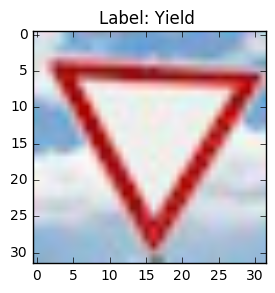

In [46]:
display_image_pred(1, new_images, top_k_val, top_k_idx, signnames, y_new_images)

True label: Keep right
pred_label1 Keep right               :  prob: 1.0000000000000000000
pred_label2 Turn left ahead          :  prob: 0.0000000000000002093
pred_label3 Yield                    :  prob: 0.0000000000000000621
pred_label4 No vehicles              :  prob: 0.0000000000000000000
pred_label5 Go straight or right     :  prob: 0.0000000000000000000


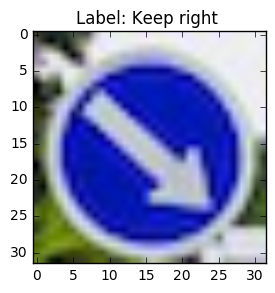

In [47]:
display_image_pred(2, new_images, top_k_val, top_k_idx, signnames, y_new_images)

True label: Beware of ice/snow
pred_label1 Slippery road            :  prob: 0.5916258096694946289
pred_label2 Beware of ice/snow       :  prob: 0.4078561961650848389
pred_label3 Bicycles crossing        :  prob: 0.0001827398082241416
pred_label4 Children crossing        :  prob: 0.0001582529803272337
pred_label5 Right-of-way at the next intersection:  prob: 0.0000654154646326788


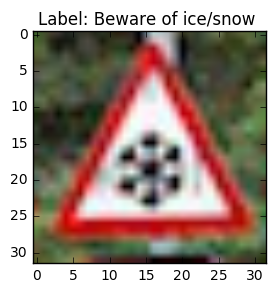

In [48]:
display_image_pred(3, new_images, top_k_val, top_k_idx, signnames, y_new_images)

True label: General caution
pred_label1 Pedestrians              :  prob: 0.9974053502082824707
pred_label2 Road narrows on the right:  prob: 0.0025602274108678102
pred_label3 Right-of-way at the next intersection:  prob: 0.0000314851749863010
pred_label4 General caution          :  prob: 0.0000026306286144973
pred_label5 Traffic signals          :  prob: 0.0000002495706326044


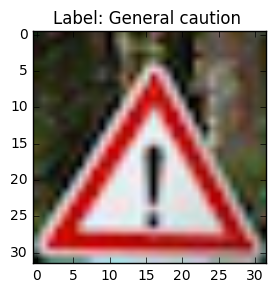

In [49]:
display_image_pred(4, new_images, top_k_val, top_k_idx, signnames, y_new_images)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.